In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
import seaborn as sns
import os
import h5py
from PIL import Image
from pathlib import Path
from scipy import signal, interpolate, stats
from tkinter import filedialog, simpledialog
from tkinter import *
import ptitprince as pt
import re
root = Tk()
root.withdraw()



''

In [84]:
def load_mouse(mat_filenames):
    
    dff_list = []
    session_list = []
    peaks_list = []
    widths_list = []
    ph_list = []
    skew_list = []

    avg_array = np.zeros([6,11])
    avg_array[avg_array == 0] = np.NaN

    i = 0

    for j in range(0,len(mat_filenames)):
        mat = sio.loadmat(mat_filenames[j])
        iscell = mat['iscell']
        #Load calcium data and iscell binary list from concatenated s2p run
        F = mat['F']
        stat = mat['stat']
        #Find integer for session
        ses_num = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", mat_filenames[j])
        ses_num = int(ses_num[2])

        #Select real cells and normalize raw calcium signal
        #Need to convert iscell to array? Probably just being stupid
        x = iscell[:,0].astype(bool)

        F_real = F[x == 1,:]
        stat_real = stat[0][x == 1]
        F_real[F_real == 0] = np.nan
        sesF_dff = []
        sespeaks = []
        seswidths = []
        sesheights = []
        sesskew = []
        #Get dimensions of real cell data
        for iter, data in enumerate(F_real):
            F_dff = stats.zscore(data)
            #F0 = np.percentile(data, 1)
            #F_dff = (data - F0)/F0
            peaks, heights= signal.find_peaks(F_dff, height=0.5, distance=7) #Minimum 0.5 Z height and 7 frames ()
            widths = signal.peak_widths(F_dff, peaks, rel_height=0.5)

            sesskew.append(stat_real[iter]['skew'])
            sesF_dff.append(F_dff)
            sespeaks.append(len(peaks))
            if len(widths[0]) > 3:
                seswidths.append(np.percentile(widths[0],95))
                sesheights.append(np.percentile(heights['peak_heights'],95))
            else:
                seswidths.append(np.NaN)
                sesheights.append(np.NaN)
        
        sesskew = np.array(sesskew)
        ses_nu = ses_num - 1
        avg_array[0,ses_nu] = len(F_real)
        if len(sespeaks) > 1:
            avg_array[1,ses_nu] = np.percentile(np.array(sespeaks),95)
        if len(seswidths) > 1:
            avg_array[2,ses_nu] = np.percentile(np.array(seswidths),95) * 0.0645
        if len(sesheights) > 1:
            avg_array[3,ses_nu] = np.percentile(np.array(sesheights),95)
        if len(sesskew) > 1:
            avg_array[4,ses_nu] = stats.skew(np.array(sesskew, dtype='float64'))
            avg_array[5,ses_nu] = len(sesskew[sesskew >= 2])

        dff_list.append(sesF_dff)
        peaks_list.append(sespeaks)
        widths_list.append(seswidths)
        skew_list.append(sesskew)
        ph_list.append(sesheights)
        session_list.append(np.repeat(ses_num, len(sespeaks)))
        
        
        
        i = i + 1
        #Make a dictionary
    


    
    #return dff_list, peaks_list, widths_list, ph_list, session_list
    return avg_array, skew_list

def load_exp():    
    num_mice = simpledialog.askinteger("Number of animals","Number of animals:")

    avg_list = []
    skew_list = []

    for i in range(num_mice):
        mat_filenames =  filedialog.askopenfilename(title = "Select Fall.mat files", filetypes = (("Mat files","*Fall.mat"),), multiple = True)
        #mouse_name = simpledialog.askstring("Mouse name", "Enter mouse name:")    
        output, skews = load_mouse(mat_filenames)
        avg_list.append(output)
        skew_list.append(skews)
        #print(output)
    return avg_list, skew_list

In [85]:
spon_array, spon_skew = load_exp()

In [86]:
evok_array, evok_skew = load_exp()

In [47]:
np.shape(evok_array)

(8, 5, 11)

In [87]:
x_E = np.stack(evok_array, axis=2)
y_E = np.nanmean(x_E, axis=2)
sem_E = np.nanstd(x_E, axis=2) / np.sqrt(np.sum(~np.isnan(x_E), axis=2))


x_S = np.stack(spon_array, axis=2)
y_S = np.nanmean(x_S,axis=2)
sem_S = np.nanstd(x_E, axis=2) / np.sqrt(np.sum(~np.isnan(x_E), axis=2))


<ipython-input-87-9b9bcd7fb77a>:2: RuntimeWarning: Mean of empty slice
  y_E = np.nanmean(x_E, axis=2)
c:\Users\tomva\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-87-9b9bcd7fb77a>:7: RuntimeWarning: Mean of empty slice
  y_S = np.nanmean(x_S,axis=2)


In [57]:
np.shape(y_E[0,:])
index = [-4,-3,-2,-1,0,1,2,3,4,5]
np.shape(index)

(10,)

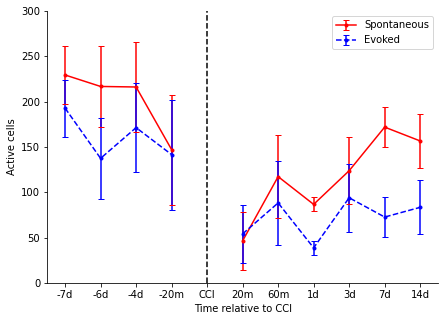

In [88]:


# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = [-4,-3,-2,-1,0,1,2,3,4,5,6]
labels = ['-7d','-6d','-4d','-20m','CCI','20m','60m','1d','3d','7d','14d']

a = ax.errorbar(index, y_S[0,:], fmt='.r-', yerr=sem_S[0,:], capsize=3)
c = ax.errorbar(index, y_E[0,:], fmt='.b--', yerr=sem_E[0,:], capsize=3)

plt.axvline(x=0, color='black', linestyle='--')

plt.legend((a,c), ('Spontaneous','Evoked'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(0,300)
plt.xticks(index, labels)
ax.set_ylabel('Active cells')
ax.set_xlabel('Time relative to CCI')

plt.savefig('2P_Cells_overdays.png')

plt.show()

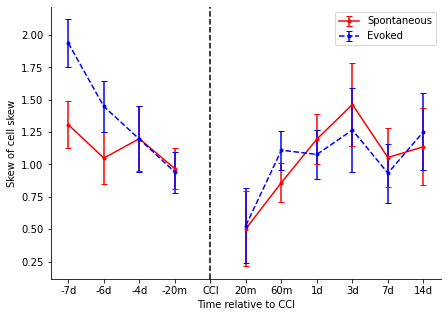

In [89]:


# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = [-4,-3,-2,-1,0,1,2,3,4,5,6]
labels = ['-7d','-6d','-4d','-20m','CCI','20m','60m','1d','3d','7d','14d']

a = ax.errorbar(index, y_S[4,:], fmt='.r-', yerr=sem_S[4,:], capsize=3)
c = ax.errorbar(index, y_E[4,:], fmt='.b--', yerr=sem_E[4,:], capsize=3)

plt.axvline(x=0, color='black', linestyle='--')

plt.legend((a,c), ('Spontaneous','Evoked'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.ylim(0,300)
plt.xticks(index, labels)
ax.set_ylabel('Skew of cell skew')
ax.set_xlabel('Time relative to CCI')

plt.savefig('Skew_of_cell_skew_overdays.png')

plt.show()

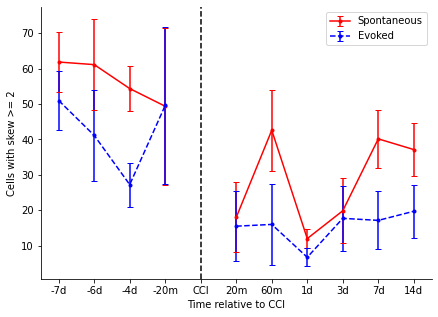

In [91]:
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = [-4,-3,-2,-1,0,1,2,3,4,5,6]
labels = ['-7d','-6d','-4d','-20m','CCI','20m','60m','1d','3d','7d','14d']

a = ax.errorbar(index, y_S[5,:], fmt='.r-', yerr=sem_S[5,:], capsize=3)
c = ax.errorbar(index, y_E[5,:], fmt='.b--', yerr=sem_E[5,:], capsize=3)

plt.axvline(x=0, color='black', linestyle='--')

plt.legend((a,c), ('Spontaneous','Evoked'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.ylim(0,300)
plt.xticks(index, labels)
ax.set_ylabel('Cells with skew >= 2')
ax.set_xlabel('Time relative to CCI')

plt.savefig('Skew_count_overdays.png')

plt.show()

In [ ]:
# Usage with a list/np.array input

index = [-4,-3,-2,-1,0,1,2,3,4,5,6]
labels = ['-7d','-6d','-4d','-20m','CCI','20m','60m','1d','3d','7d','14d']
dx = np.concatenate(session_list)
dy = np.concatenate(ph_list)
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)
plt.ylim(1.5,6)
plt.ylabel('Event peak heights (Z)')
plt.xlabel('Session')
plt.title('Peak heights over sessions')
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

In [41]:
np.sum(np.isnan(x_E), axis=2)

array([[0, 1, 0, 0, 8, 2, 2, 1, 1, 1, 1],
       [0, 1, 0, 0, 8, 2, 2, 1, 1, 1, 1],
       [0, 1, 0, 0, 8, 2, 3, 1, 1, 1, 1],
       [0, 1, 0, 0, 8, 2, 3, 1, 1, 1, 1],
       [0, 1, 0, 0, 8, 2, 2, 1, 1, 1, 1]])

In [23]:
to_write = np.stack(avg_list, axis=0)
print(np.shape(to_write))

(6, 5, 11)


In [24]:
sname = 'Evoked' 

In [12]:
sname = 'Spontaneous'

In [9]:
y[0,:]

array([229.375     , 216.71428571, 216.125     , 147.        ,
                nan,  46.33333333, 117.2       ,  86.57142857,
       123.71428571, 171.83333333, 156.57142857])

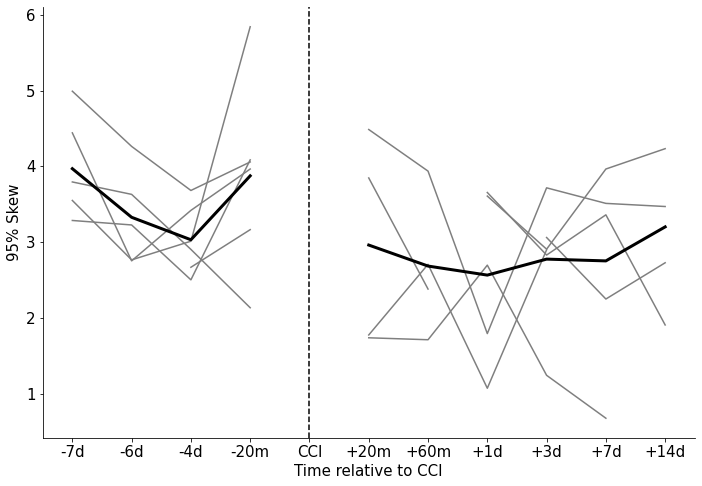

In [25]:
plt.rc('font', size=15)


fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[4,:,:],'tab:grey')
ax.plot(y[4,:],'k',lw=3)
plt.ylabel('95% Skew')
plt.xlabel('Time relative to CCI')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageskewofskew.eps'.format(sname))
plt.show()

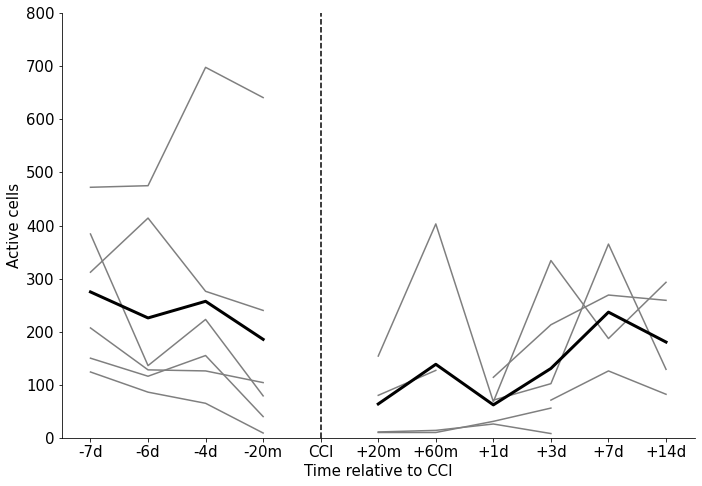

In [14]:
plt.rc('font', size=15)


fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[0,:,:],'tab:grey')
ax.plot(y[0,:],'k',lw=3)
plt.ylabel('Active cells')
plt.xlabel('Time relative to CCI')
plt.ylim(0,800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_activecells.eps'.format(sname))
plt.show()

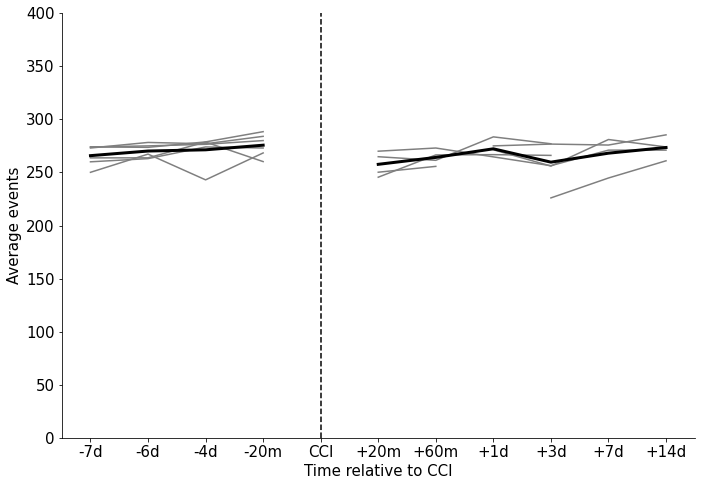

In [15]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[1,:,:],'tab:grey')
ax.plot(y[1,:],'k',lw=3)
plt.ylabel('Average events')
plt.xlabel('Time relative to CCI')
plt.ylim(0,400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageevents.eps'.format(sname))
plt.show()

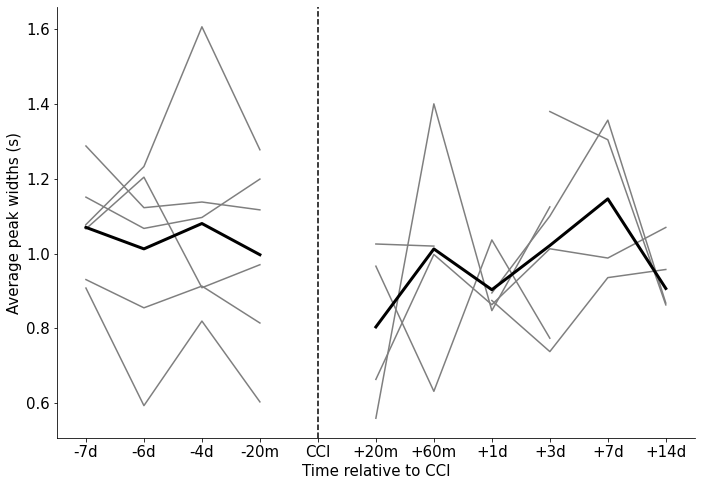

In [19]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[2,:,:],'tab:grey')
ax.plot(y[2,:],'k',lw=3)
plt.ylabel('Average peak widths (s)')
plt.xlabel('Time relative to CCI')
#plt.ylim(0,0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageeventwidths.eps'.format(sname))
plt.show()

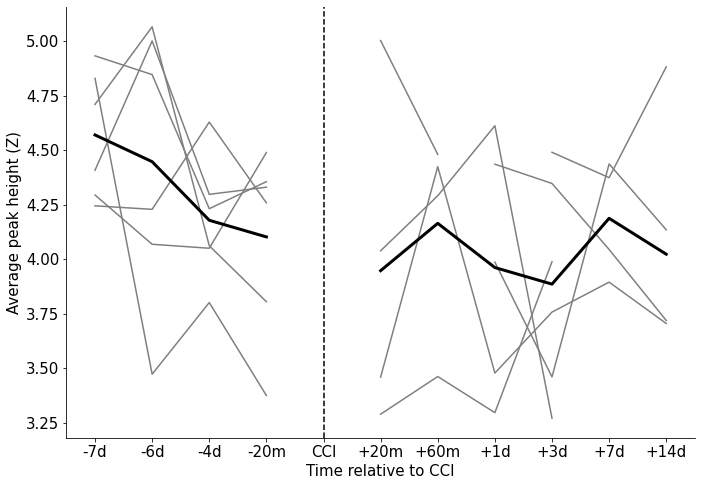

In [18]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[3,:,:],'tab:grey')
ax.plot(y[3,:],'k',lw=3)
plt.ylabel('Average peak height (Z)')
plt.xlabel('Time relative to CCI')
#plt.ylim(0,2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageeventheights.eps'.format(sname))
plt.show()

In [ ]:
#Need to make a dataframe 

In [46]:
avg_array[1,:]

array([ 74.32371795,  73.18115942,  83.6884058 ,  89.02083333,
         0.        , 102.8       ,  71.3       , 100.5483871 ,
        79.58928571,   0.        ,  81.1294964 ])

In [26]:
# Usage with a list/np.array input
dx = np.concatenate(session_list)
dy = np.concatenate(ph_list)
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)
plt.ylim(1.5,6)
plt.ylabel('Event peak heights (Z)')
plt.xlabel('Session')
plt.title('Peak heights over sessions')
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

NameError: name 'session_list' is not defined

[Text(0, 0, 'B1'),
 Text(1, 0, 'B2'),
 Text(2, 0, 'B3'),
 Text(3, 0, 'C4'),
 Text(4, 0, 'T6'),
 Text(5, 0, 'T7'),
 Text(6, 0, 'T8'),
 Text(7, 0, 'T9'),
 Text(8, 0, 'T11')]

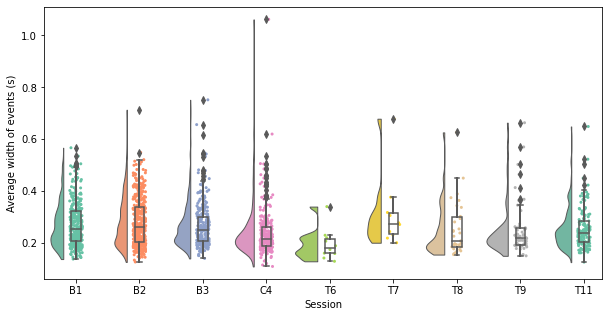

In [ ]:
# Usage with a list/np.array input
dx = np.concatenate(session_list)
dy = np.concatenate(widths_list)*0.0645
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)

plt.ylabel('Average width of events (s)')
plt.xlabel('Session')
#plt.ylim(0,190)
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

In [ ]:
num_mice = simpledialog.askinteger("Number of animals","Number of animals:")